# kNN-VC and LinearVC experiments on LibriSpeech

Herman Kamper, 2024-2025

In [1]:
from datetime import datetime
from numpy import linalg
from pathlib import Path
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm
import celer
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
import time
import torch
import torchaudio

from utils import fast_cosine_dist

In [2]:
device = "cuda"

## Models

In [3]:
wavlm = torch.hub.load("bshall/knn-vc", "wavlm_large", trust_repo=True, device=device)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [4]:
hifigan, _ = torch.hub.load("bshall/knn-vc", "hifigan_wavlm", trust_repo=True, device=device, prematched=True)

Removing weight norm...
[HiFiGAN] Generator loaded with 16,523,393 parameters.


Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master


## LinearVC (single utterance)

In [5]:
subset = "dev-clean"
feats_dir = Path(f"/home/kamperh/scratch/{subset}/wavlm_exclude")
wav_dir = Path(f"/home/kamperh/endgame/datasets/librispeech/LibriSpeech/{subset}")

n_frames = 8192  # 15000
k_top = 1

In [6]:
feats_dict = {}
print("Reading from:", feats_dir)
for speaker_feats_fn in tqdm(sorted(feats_dir.glob("*.npy"))):
    speaker = speaker_feats_fn.stem
    feats_dict[speaker] = np.load(speaker_feats_fn)
print("No. speakers:", len(feats_dict))

Reading from: /home/kamperh/scratch/dev-clean/wavlm_exclude


  0%|          | 0/40 [00:00<?, ?it/s]

No. speakers: 40


In [66]:
source = "1272"
target = "1462"

# Features
source_feats = feats_dict[source][:n_frames, :]
target_feats = feats_dict[target]
source_feats = torch.from_numpy(source_feats).float().to(device)
target_feats = torch.from_numpy(target_feats).float().to(device)

dists = fast_cosine_dist(source_feats, target_feats, device=device)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

# Matching
bias = None

# # Additive
# delta = torch.mean(linear_target, axis=0) - torch.mean(source_feats, axis=0)
# W = None
# bias = delta

# # Bias only
# W = None
# bias = np.mean(feats_dict[target], axis=0) - np.mean(feats_dict[source], axis=0)

# Linear without bias
W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

np.save(f"doc/W_{source}-{target}.npy", W)

# # Linear with bias
# linear = LinearRegression(fit_intercept=True).fit(
#     source_feats.cpu(), linear_target.cpu()
# )
# W = linear.coef_.T
# bias = linear.intercept_

# # Orthogonal
# W, _ = scipy.linalg.orthogonal_procrustes(source_feats.cpu(), linear_target.cpu())

# # Orthogonal with bias
# source_offset = np.mean(source_feats.squeeze().cpu().numpy(), axis=0)
# target_offset = np.mean(linear_target.squeeze().cpu().numpy(), axis=0)
# source_centred = source_feats.squeeze().cpu().numpy() - source_offset
# target_centred = linear_target.squeeze().cpu().numpy() - target_offset
# W, _ = scipy.linalg.orthogonal_procrustes(source_centred, target_centred)
# bias = target_offset - source_offset @ W

# # Lasso
# linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.coef_.T

# # Ridge
# linear = Ridge(alpha=1e4, fit_intercept=False).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.coef_.T

/tmp/ipykernel_3050713/348570995.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())


In [14]:
source_wav_fn = Path("/home/kamperh/endgame/datasets/librispeech/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac")
source_wav, _ = torchaudio.load(source_wav_fn)
display.Audio(source_wav.squeeze().cpu(), rate=16000)

In [15]:
source_wav = source_wav.to(device)
with torch.inference_mode():
    source_feats, _ = wavlm.extract_features(
        source_wav, output_layer=6
    )

W_source_to_target = W
bias_source_to_target = bias

source_to_target_feats = source_feats
if W_source_to_target is not None:
    if not torch.is_tensor(bias_source_to_target):
        W_source_to_target = (
            torch.from_numpy(W_source_to_target).float().to(device)
        )                
    source_to_target_feats = source_to_target_feats @ W_source_to_target
if bias_source_to_target is not None:
    if not torch.is_tensor(bias_source_to_target):
        bias_source_to_target = torch.from_numpy(bias_source_to_target).float().to(device)
    source_to_target_feats = source_to_target_feats + bias_source_to_target

# # Additive
# # source_to_target_feats = source_feats + delta  # additive transformation

# # Linear
# W_source_to_target = torch.from_numpy(W).float().to(device)
# source_to_target_feats = source_feats @ W_source_to_target
# if bias is not None:
#     bias_source_to_target = torch.from_numpy(bias).float().to(device)
#     source_to_target_feats += 1*bias_source_to_target

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [16]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [10]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [23]:
np.abs(W_numpy).T[35, :10]

array([0.08519878, 0.13012202, 0.10155219, 0.07578605, 0.14508055,
       0.06553739, 0.00133154, 0.0286    , 0.00058291, 0.04118913],
      dtype=float32)

(300.0, 0.0)

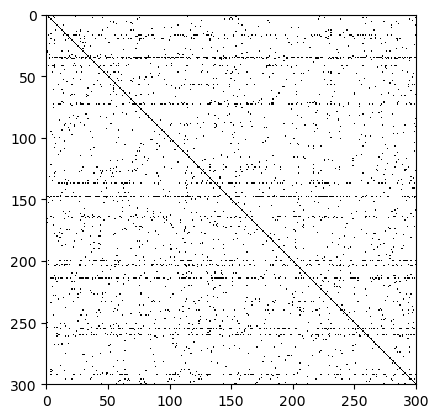

In [64]:
fig, ax = plt.subplots(1, 1)

threshold = 0.06
W_numpy = np.abs(W.copy())

# W_numpy[np.diag_indices_from(W_numpy)] = 0
# W_numpy[np.where(W_numpy < threshold)] = 0
# ax.imshow(W_numpy.T, cmap="binary", aspect="equal", interpolation="none")

W_numpy_threshold = np.zeros_like(W_numpy)
W_numpy_threshold[np.where(W_numpy > threshold)] = 1
ax.imshow(W_numpy_threshold.T, cmap="binary", aspect="equal", interpolation="none")

ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

(300.0, 0.0)

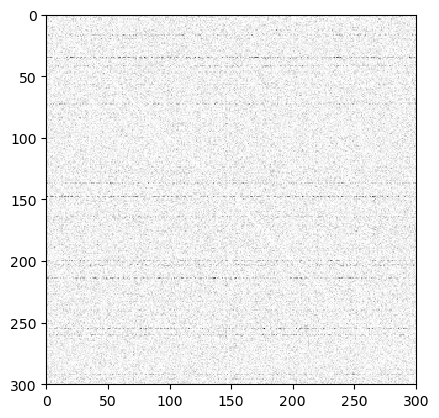

In [25]:
fig, ax = plt.subplots(1, 1)
W_numpy = W.copy()
W_numpy[np.diag_indices_from(W_numpy)] = 0
ax.imshow(np.abs(W_numpy).T, cmap="binary", aspect="equal", interpolation="none")
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

Matrix rank: 1024
No. parameters for low rank: 2,097,152
Proportion zero: 0.32%
No. non-zero elements: 1,045,242 out of 1,048,576


(300.0, 0.0)

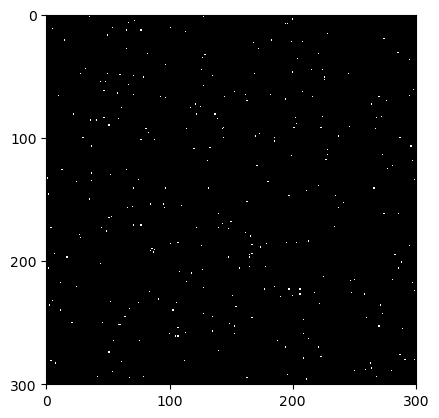

In [33]:
# Matrix properties
tol = 1e-4
print("Matrix rank:", linalg.matrix_rank(W, tol=tol))
print(
    "No. parameters for low rank: {:,d}".format(
        linalg.matrix_rank(W, tol=tol) * W.shape[0] * 2
    )
)
print(
    "Proportion zero: {:.2f}%".format(
        len(np.where(np.abs(W) < tol)[0]) / W.shape[0] ** 2 * 100
    )
)
print(
    "No. non-zero elements: {:,d} out of {:,d}".format(
        len(np.where(np.abs(W) > tol)[0]),
        W.shape[0] * W.shape[1]
    )
)

W_numpy = W.copy()
matrix = W_numpy.copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
fig, ax = plt.subplots(1, 1)
ax.imshow(matrix.T, cmap="binary", aspect="equal", interpolation="none")

# ax.set_title(r"$\mathbf{W}^\top$")
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

## LinearVC (dataset)

In [9]:
# Objective
# exp_tag = "2024-09-22"
# exp_tag = "2024-10-15"
# exp_tag = "2024-10-18"
# exp_tag = "2024-11-12_lasso3.0"
# exp_tag = "2024-11-12_lasso0.4"
# exp_tag = "2024-12-04_procrustes_bias"
# exp_tag = "2024-12-04_linear_bias"
# exp_tag = "2024-12-04_additive"
# exp_tag = "2025-01-07"  # with bias
# exp_tag = "2025-01-07_procrustes_bias"
# exp_tag = "2025-01-07_procrustes"
# exp_tag = "2025-01-07_bias"
# rank = 20
# exp_tag = f"2025-01-07_fact_r{rank}"
exp_tag = "2025-05-29_orthogonal"
# subset = "test-clean"
subset = "dev-clean"
eval_csv = Path(f"data/speaker-sim-{subset}.csv")

# # Subjective
# test_type = "naturalness"  # "naturalness"  # "speakersim"
# # exp_tag = f"2025-01-13_{test_type}"
# rank = 100
# exp_tag = f"2025-01-13_{test_type}_r{rank}"
# subset = "test-clean"
# eval_csv = Path(f"data/{test_type}_julian_{subset}.csv")

feats_dir = Path(f"/home/kamperh/scratch/{subset}/wavlm_exclude")
wav_dir = Path(f"/home/kamperh/endgame/datasets/librispeech/LibriSpeech/{subset}")
output_dir = Path(f"/home/kamperh/scratch/linearvc/{subset}/{exp_tag}")

n_frames = 8192  # 15000
k_top = 1

In [10]:
print("Writing to:", output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

Writing to: /home/kamperh/scratch/linearvc/dev-clean/2025-05-29_orthogonal


In [11]:
feats_dict = {}
print("Reading from:", feats_dir)
for speaker_feats_fn in tqdm(sorted(feats_dir.glob("*.npy"))):
    speaker = speaker_feats_fn.stem
    feats_dict[speaker] = np.load(speaker_feats_fn)
print("No. speakers:", len(feats_dict))

Reading from: /home/kamperh/scratch/dev-clean/wavlm_exclude


  0%|          | 0/40 [00:00<?, ?it/s]

No. speakers: 40


In [12]:
# Projection matrices
projmats = {}
for source in tqdm(feats_dict):
    for target in tqdm(feats_dict, leave=False):
# for source in tqdm(["6319"]):
#     for target in tqdm(["5694"], leave=False):
        if source == target:
            continue

        # Features
        source_feats = feats_dict[source][:n_frames, :]
        # target_feats = feats_dict[target][:n_frames, :]
        target_feats = feats_dict[target]
        source_feats = torch.from_numpy(source_feats).float().to(device)
        target_feats = torch.from_numpy(target_feats).float().to(device)

        # Matching
        dists = fast_cosine_dist(source_feats, target_feats, device=device)
        best = dists.topk(k=k_top, largest=False, dim=-1)        
        linear_target = target_feats[best.indices].mean(dim=1)

        bias = None

        # # Additive
        # delta = torch.mean(linear_target, axis=0) - torch.mean(source_feats, axis=0)
        # W = None
        # bias = delta

        # # Bias only
        # W = None
        # bias = np.mean(feats_dict[target], axis=0) - np.mean(feats_dict[source], axis=0)

        # # Linear without bias
        # W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

        # # Linear with bias
        # linear = LinearRegression(fit_intercept=True).fit(
        #     source_feats.cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T
        # bias = linear.intercept_        

        # Orthogonal
        W, _ = scipy.linalg.orthogonal_procrustes(source_feats.cpu(), linear_target.cpu())

        # # Orthogonal with bias
        # source_offset = np.mean(source_feats.squeeze().cpu().numpy(), axis=0)
        # target_offset = np.mean(linear_target.squeeze().cpu().numpy(), axis=0)
        # source_centred = source_feats.squeeze().cpu().numpy() - source_offset
        # target_centred = linear_target.squeeze().cpu().numpy() - target_offset
        # W, _ = scipy.linalg.orthogonal_procrustes(source_centred, target_centred)
        # bias = target_offset - source_offset @ W        

        # # Lasso
        # linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
        # # linear = celer.Lasso(alpha=3.0, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T

        # # Ridge
        # linear = Ridge(alpha=1e4, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T

        # W = torch.from_numpy(W).float().to(device)
        projmats[f"{source}-{target}"] = (W, bias)

    #     assert False
    #     break
    # break

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Skip cell below if one of the transformations in the preceding cell was used.

In [9]:
# Content factorisation approach

# rank = 64

XS = []
speakers = sorted(feats_dict)
for speaker in speakers:
    XS.append(feats_dict[speaker][:n_frames, :])

def align(src, refs):
    neighbors = NearestNeighbors(n_neighbors=1, metric="cosine")
    neighbors.fit(refs)
    dists, indices = neighbors.kneighbors(src)
    return refs[indices.squeeze(), :]

print("Matching:")
XS = [align(XS[0], X) for X in tqdm(XS)]
XS = np.concatenate(XS, axis=-1)
XS = np.float32(XS)

print(datetime.now())
print("SVD")
U, S, VT = randomized_svd(XS, n_components=rank)
print(datetime.now())

print("Reshaping")
VT = VT.reshape(-1, len(speakers), 1024).swapaxes(0, 1)
transforms = {
    f"{speaker}": VT[i, :, :] for i, speaker in enumerate(speakers)
}

print("Projection matrices:")
projmats = {}
for source in tqdm(feats_dict):
    for target in tqdm(feats_dict, leave=False):
        if source == target:
            continue
        W = np.linalg.pinv(transforms[source]) @ transforms[target]
        projmats[f"{source}-{target}"] = (W, None)

Matching:


  0%|          | 0/40 [00:00<?, ?it/s]

2025-01-14 09:40:02.350645
SVD
2025-01-14 09:40:04.034720
Reshaping
Projection matrices:


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [52]:
# output_dir.mkdir(parents=True, exist_ok=True)
# npz_fn = output_dir / f"projmats.npz"

# if W is None or bias is None:
#     tmp = {}
#     for key in projmats:
#         if W is None:
#             tmp[key] = projmats[key][1]
#         elif bias is None:
#             tmp[key] = projmats[key][1]

#     print("Writing:", npz_fn)
#     np.savez_compressed(npz_fn, **tmp)
# else:
    
#     print("Writing:", npz_fn)
#     np.savez_compressed(npz_fn, **projmats)


# # print("Reading:", npz_fn)
# # projmats = np.load(npz_fn)

In [13]:
output_dir.mkdir(parents=True, exist_ok=True)
print("Writing to:", output_dir)
start_time = time.time()
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, _, _) = line.split(",")
            # (source, target, source_key, _, _) = line.split(",")  # VCTK

            source_key_split = source_key.split("-")
            source_wav_fn = (
                wav_dir
                / source_key_split[0]
                / source_key_split[1]
                / source_key.split("/")[0]
            ).with_suffix(".flac")
            # # VCTK
            # source_wav_fn = (
            #     wav_dir / source / Path(source_key).stem
            # ).with_suffix(".wav")
           
            source_wav, _ = torchaudio.load(source_wav_fn)
            source_wav = source_wav.to(device)
            with torch.inference_mode():
                source_feats, _ = wavlm.extract_features(
                    source_wav, output_layer=6
                )

            W_source_to_target = projmats[f"{source}-{target}"][0]
            bias_source_to_target = projmats[f"{source}-{target}"][1]

            source_to_target_feats = source_feats
            if W_source_to_target is not None:
                
                if not torch.is_tensor(bias_source_to_target):
                    W_source_to_target = (
                        torch.from_numpy(W_source_to_target).float().to(device)
                    )                
                source_to_target_feats = source_to_target_feats @ W_source_to_target
            if bias_source_to_target is not None:
                if not torch.is_tensor(bias_source_to_target):
                    bias_source_to_target = torch.from_numpy(bias_source_to_target).float().to(device)
                source_to_target_feats = source_to_target_feats + bias_source_to_target

            with torch.inference_mode():
                wav_hat = hifigan(source_to_target_feats).squeeze(0)            

            cur_output_dir = Path(output_dir) / source_key.split("/")[0]
            cur_output_dir.mkdir(parents=True, exist_ok=True)
            output_fn = (cur_output_dir / source_key.split("/")[1]).with_suffix(
                ".wav"
            )
            torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)

            print(source_wav_fn)
            
            print(output_fn)
            assert False

end_time = time.time()
print(f"Time: {(end_time - start_time)/60:.2f} minutes")

Writing to: /home/kamperh/scratch/linearvc/dev-clean/2025-05-29_orthogonal


  0%|          | 0/15601 [00:00<?, ?it/s]

/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987296916/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


KeyError: '6319-5694'

In [11]:
class Arguments: pass
args = Arguments()
args.format = "librispeech"
args.eval_csv = eval_csv
args.converted_dir = output_dir
args.groundtruth_dir = wav_dir

print("Run:")
print(
    f"./speaker_similarity.py --format {args.format}"
    f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
)
print(
    f"./intelligibility.py --format {args.format} {args.converted_dir}"
    f" {args.groundtruth_dir}"
    # f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"
)

# speaker_similarity(args)

Run:
./speaker_similarity.py --format librispeech data/speaker-sim-dev-clean.csv /home/kamperh/scratch/linearvc/dev-clean/2025-01-07_fact_r20 /home/kamperh/endgame/datasets/librispeech/LibriSpeech/dev-clean
./intelligibility.py --format librispeech /home/kamperh/scratch/linearvc/dev-clean/2025-01-07_fact_r20 /home/kamperh/endgame/datasets/librispeech/LibriSpeech/dev-clean


Results on `test-clean`:

               eer
    mean  0.335769
    std   0.096417

    WER: 4.93% +- 0.06%
    CER: 2.55% +- 0.03%

## kNN-VC (dataset)

In [19]:
# Objective
# exp_tag = "2024-09-17"
# exp_tag = "2024-10-15"
# exp_tag = "2025-01-07"
# subset = "test-clean"
# eval_csv = Path(f"data/speaker-sim-{subset}.csv")
# eval_csv = Path("data/speakersim_vctk_english.csv")

# Subjective
test_type = "naturalness"  # "speakersim"
exp_tag = f"2025-01-13_{test_type}"
subset = "test-clean"
eval_csv = Path(f"data/{test_type}_julian_{subset}.csv")

feats_dir = Path(f"/home/kamperh/scratch/{subset}/wavlm_exclude")
wav_dir = Path(f"/home/kamperh/endgame/datasets/librispeech/LibriSpeech/{subset}")
output_dir = Path(f"/home/kamperh/scratch/knnvc/{subset}/{exp_tag}")

n_frames = None  # 15000
k_top = 4

In [15]:
feats_dict = {}
print("Reading from:", feats_dir)
sizes = []
for speaker_feats_fn in tqdm(sorted(feats_dir.glob("*.npy"))):
    speaker = speaker_feats_fn.stem
    feats_dict[speaker] = (
        torch.from_numpy(np.load(speaker_feats_fn))[:n_frames, :]
        .float()
        .to(device)
    )
    
    sizes.append(speaker_feats_fn.stat().st_size)
print("No. speakers:", len(feats_dict))
print(f"Average file size: {np.mean(sizes)/1024/1024:.2f}Mb")

Reading from: /home/kamperh/scratch/test-clean/wavlm_exclude


  0%|          | 0/40 [00:00<?, ?it/s]

No. speakers: 40
Average file size: 42.20Mb


In [20]:
output_dir.mkdir(parents=True, exist_ok=True)
print("Writing to:", output_dir)
start_time = time.time()
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, _, _) = line.split(",")
            # (source, target, source_key, _, _) = line.split(",")  # VCTK

            # print(f"Time: {(time.time() - start_time):.4f} seconds")
            # start_time = time.time()
            
            source_key_split = source_key.split("-")
            source_wav_fn = (
                wav_dir
                / source_key_split[0]
                / source_key_split[1]
                / source_key.split("/")[0]
            ).with_suffix(".flac")
            # # VCTK
            # source_wav_fn = (
            #     wav_dir / source / Path(source_key).stem
            # ).with_suffix(".wav")
            
            # Features
            source_wav, _ = torchaudio.load(source_wav_fn)
            source_wav = source_wav.to(device)
            with torch.inference_mode():
                source_feats, _ = wavlm.extract_features(
                    source_wav, output_layer=6
                )
            target_feats = feats_dict[target]

            # Matching
            dists = fast_cosine_dist(
                source_feats.squeeze(), target_feats, device=device
            )
            best = dists.topk(k=k_top, largest=False, dim=-1)
            source_to_target_feats = target_feats[best.indices].mean(dim=1)[None]

            with torch.inference_mode():
                wav_hat = hifigan(source_to_target_feats).squeeze(0)            

            cur_output_dir = Path(output_dir) / source_key.split("/")[0]
            cur_output_dir.mkdir(parents=True, exist_ok=True)
            output_fn = (cur_output_dir / source_key.split("/")[1]).with_suffix(
                ".wav"
            )
            torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)

            # print(output_fn)
            # assert False

end_time = time.time()
print(f"Time: {(end_time - start_time)/60:.2f} minutes")

Writing to: /home/kamperh/scratch/knnvc/test-clean/2025-01-13_naturalness


  0%|          | 0/61 [00:00<?, ?it/s]

Time: 0.08 minutes


In [9]:
class Arguments: pass
args = Arguments()
args.format = "librispeech"
args.eval_csv = eval_csv
args.converted_dir = output_dir
args.groundtruth_dir = wav_dir

print("Run:")
print(
    f"./speaker_similarity.py --format {args.format}"
    f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
)
print(
    f"./intelligibility.py --format {args.format} {args.converted_dir}"
    f" {args.groundtruth_dir}"    
    # f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"   
)

# speaker_similarity(args)

Run:
./speaker_similarity.py --format librispeech data/speaker-sim-test-clean.csv /home/kamperh/scratch/knnvc/test-clean/2025-01-07 /home/kamperh/endgame/datasets/librispeech/LibriSpeech/test-clean
./intelligibility.py --format librispeech /home/kamperh/scratch/knnvc/test-clean/2025-01-07 /home/kamperh/endgame/datasets/librispeech/LibriSpeech/test-clean


Results:

               eer
    mean  0.389744
    std   0.094324

    WER: 5.57% +- 0.07%
    CER: 2.87% +- 0.04%